# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import random


2023-08-07 10:07:27.670677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Set Random Seed

In [2]:
random.seed(2971)

#### Read data set

In [3]:
data = pd.read_csv(filepath_or_buffer=r"/BackUpFolder/LSTM BTC/BTCUSDKRAKEN", index_col="Date")

#### View data info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1380 non-null   float64
 1   High               1380 non-null   float64
 2   Low                1380 non-null   float64
 3   Close              1380 non-null   float64
 4   Volume (BTC)       1380 non-null   float64
 5   Volume (Currency)  1380 non-null   float64
 6   Weighted Price     1380 non-null   float64
dtypes: float64(7)
memory usage: 86.2+ KB


#### View data rows

In [5]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


#### Check latest date of data

In [6]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-10-13,5429.8,5854.4,5380.1,5640.0,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.7,5800.0,5556.1,5800.0,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.0,5840.4,5462.1,5680.0,4536.386215,2.545265e+07,5610.777658
2017-10-16,5673.2,5776.6,5550.0,5738.8,3134.620657,1.778638e+07,5674.172630
2017-10-17,5738.7,5759.9,5535.1,5577.8,3322.439554,1.869327e+07,5626.368279


#### Plot line graph base on `Weighted Price`

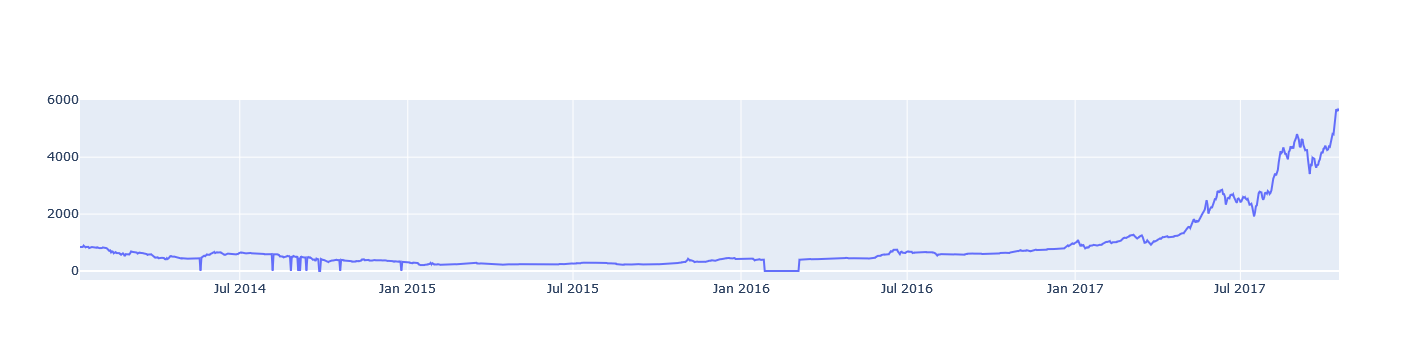

In [7]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [8]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

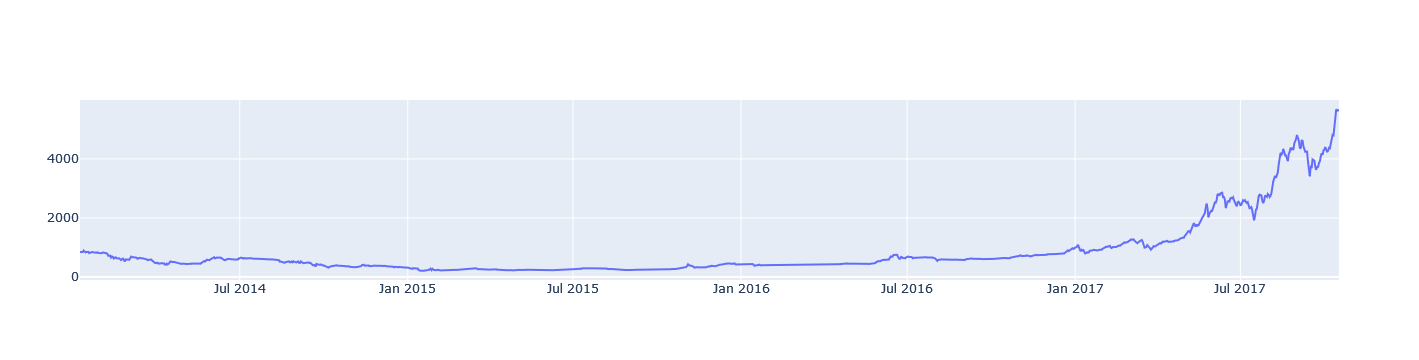

In [9]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [10]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
scaled

array([[0.11690941],
       [0.11642168],
       [0.11504118],
       ...,
       [0.98506284],
       [0.99660337],
       [0.98790085]], dtype=float32)

#### Split 70% of data for training and 30% for testing

In [12]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


#### Create function for creating dataset with look back

In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [14]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


#### Reshape X for model training

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [16]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

2023-08-07 10:08:24.079940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-07 10:08:24.094973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-07 10:08:24.095239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-07 10:08:24.097378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-07 10:08:24.097561: I tensorflow/compile

#### Running The Second LSTM Model With Two Additional Dense Layers And Different Batch Size

In [19]:
secondModel = Sequential()
secondModel.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
secondModel.add(Dense(1))
secondModel.add(Dense(4))
secondModel.add(Dense(1))
secondModel.compile(loss='mae', optimizer='adam')
secondHistory = secondModel.fit(trainX, trainY, epochs=300, batch_size=200, validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/300
5/5 - 2s - loss: 0.0348 - val_loss: 0.2791 - 2s/epoch - 351ms/step
Epoch 2/300
5/5 - 0s - loss: 0.0273 - val_loss: 0.2643 - 46ms/epoch - 9ms/step
Epoch 3/300
5/5 - 0s - loss: 0.0241 - val_loss: 0.2543 - 38ms/epoch - 8ms/step
Epoch 4/300
5/5 - 0s - loss: 0.0241 - val_loss: 0.2488 - 36ms/epoch - 7ms/step
Epoch 5/300
5/5 - 0s - loss: 0.0241 - val_loss: 0.2470 - 36ms/epoch - 7ms/step
Epoch 6/300
5/5 - 0s - loss: 0.0239 - val_loss: 0.2473 - 39ms/epoch - 8ms/step
Epoch 7/300
5/5 - 0s - loss: 0.0234 - val_loss: 0.2484 - 37ms/epoch - 7ms/step
Epoch 8/300
5/5 - 0s - loss: 0.0232 - val_loss: 0.2492 - 36ms/epoch - 7ms/step
Epoch 9/300
5/5 - 0s - loss: 0.0231 - val_loss: 0.2493 - 36ms/epoch - 7ms/step
Epoch 10/300
5/5 - 0s - loss: 0.0230 - val_loss: 0.2486 - 38ms/epoch - 8ms/step
Epoch 11/300
5/5 - 0s - loss: 0.0229 - val_loss: 0.2475 - 39ms/epoch - 8ms/step
Epoch 12/300
5/5 - 0s - loss: 0.0228 - val_loss: 0.2459 - 38ms/epoch - 8ms/step
Epoch 13/300
5/5 - 0s - loss: 0.0227 - val_loss: 

#### Plot Line Graph To Show Amount Loss For The First Model

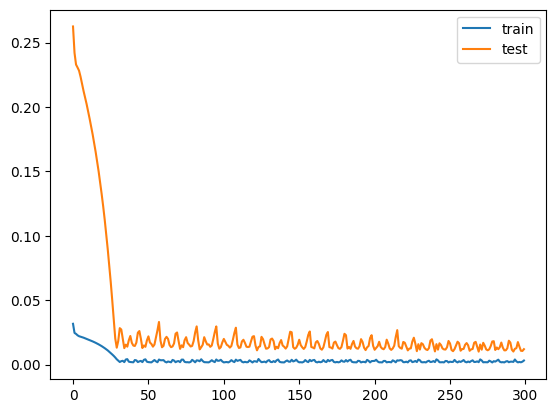

In [20]:
pyplot.plot(history.history['loss'], label='LOSS')
pyplot.plot(history.history['val_loss'], label='VALIDATION LOSS')
pyplot.legend()
pyplot.show()

#### Second Graph For The Second Model

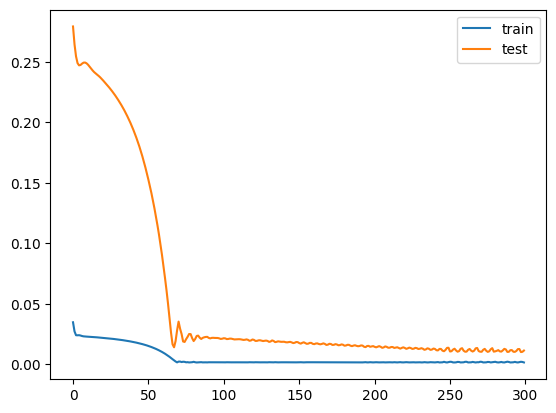

In [21]:
pyplot.plot(secondHistory.history['loss'], label='LOSS')
pyplot.plot(secondHistory.history['val_loss'], label='VALIDATION LOSS')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY (First Model)

13/13 [==============================] - 0s 3ms/step


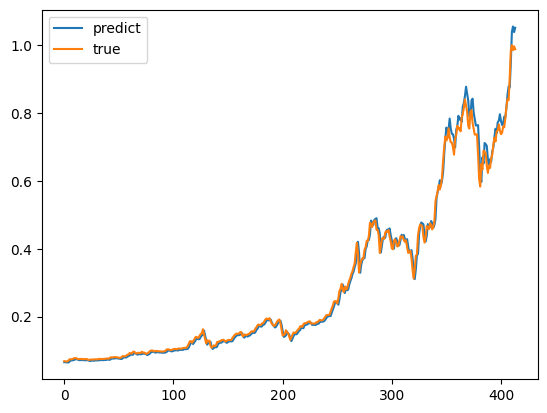

In [23]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY (Second Model)

13/13 [==============================] - 0s 3ms/step


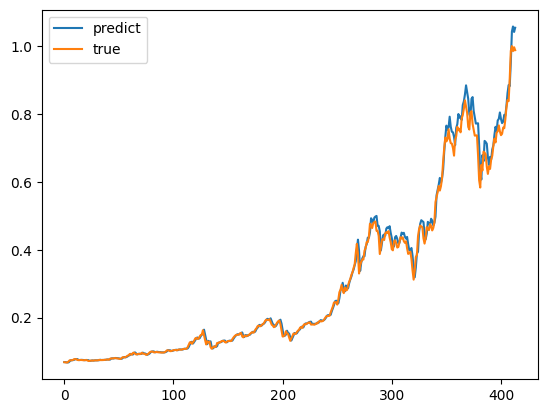

In [24]:
yPred = secondModel.predict(testX)
pyplot.plot(yPred, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [25]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
yPred_inverse = scaler.inverse_transform(yPred.reshape(-1,1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [26]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
secRMSE = sqrt(mean_squared_error(testY_inverse , yPred_inverse))
print('Test RMSE: %.3f' % rmse)
print('Second Test RMSE: %.3f' % secRMSE )

Test RMSE: 102.960
Second Test RMSE: 113.171


#### MAE

In [27]:
MAE = mean_absolute_error(testY_inverse, yhat_inverse)
secMAE = mean_absolute_error(testY_inverse, yPred_inverse)
print('Test MAE: %.3f' % MAE)
print('Second Test MAE: %.3f' %secMAE )

Test MAE: 65.706
Second Test MAE: 62.889


#### Plot line graph with Y as USD (First Model)

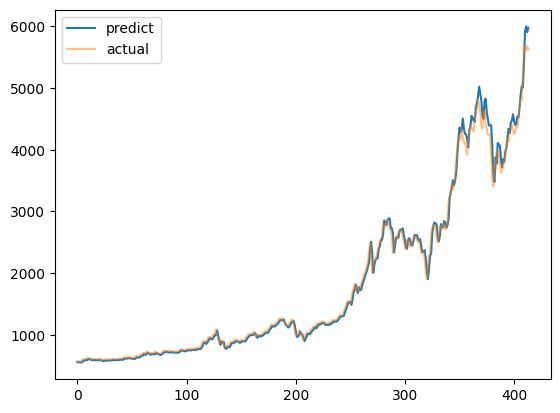

In [28]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Plot line graph with Y as USD (Second Model)

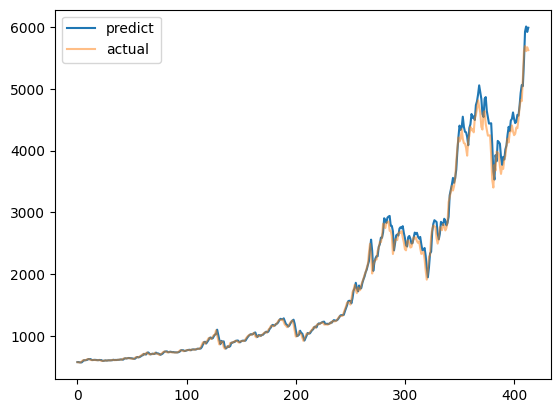

In [29]:
pyplot.plot(yPred_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [30]:
predictDates = data.tail(len(testX)).index

#### Reshape testY, yPred and yhat for plotly

In [31]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
yPred_reshape = yPred_inverse.reshape(len(yPred_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD (First Model)

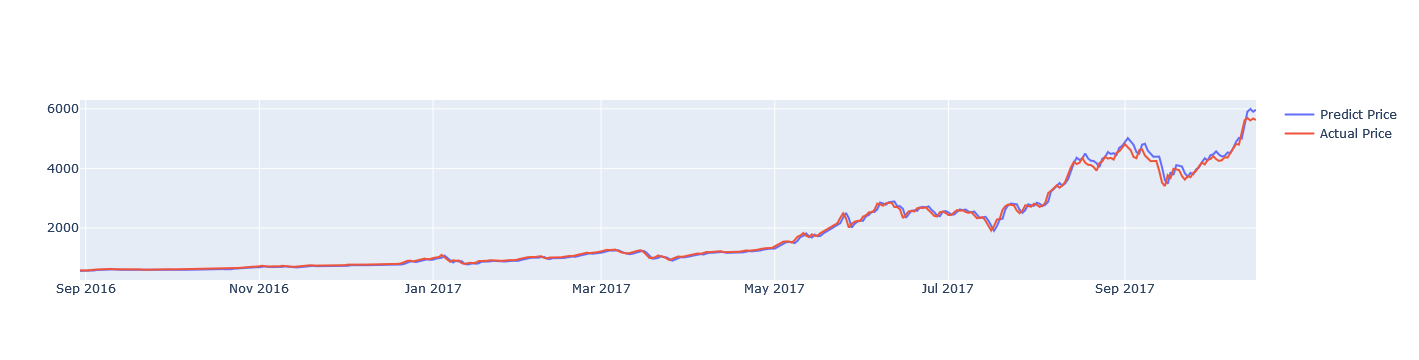

In [32]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

#### Plot predicted and actual line graph with X=dates, Y=USD (Second Model)

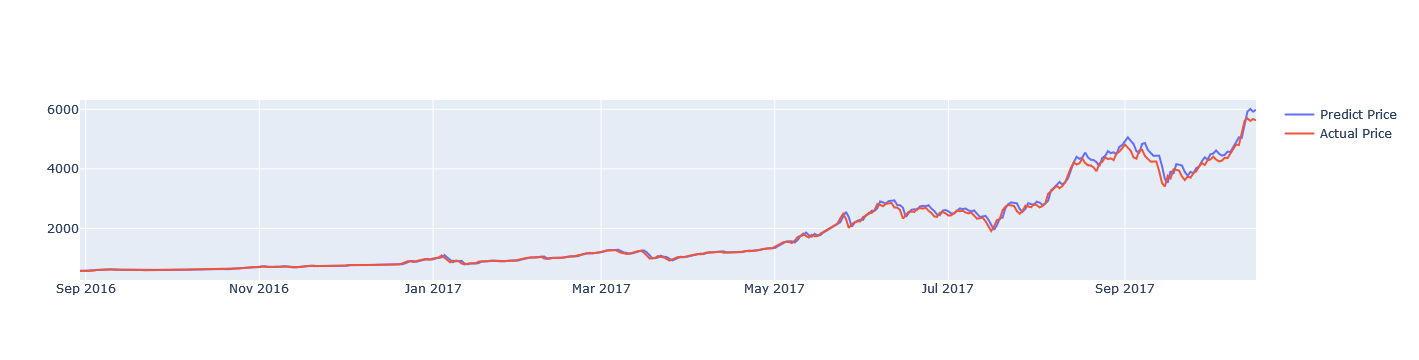

In [33]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
pred_chart = go.Scatter(x=predictDates, y=yPred_reshape, name= 'Predict Price')
py.iplot([pred_chart, actual_chart])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

<Axes: >

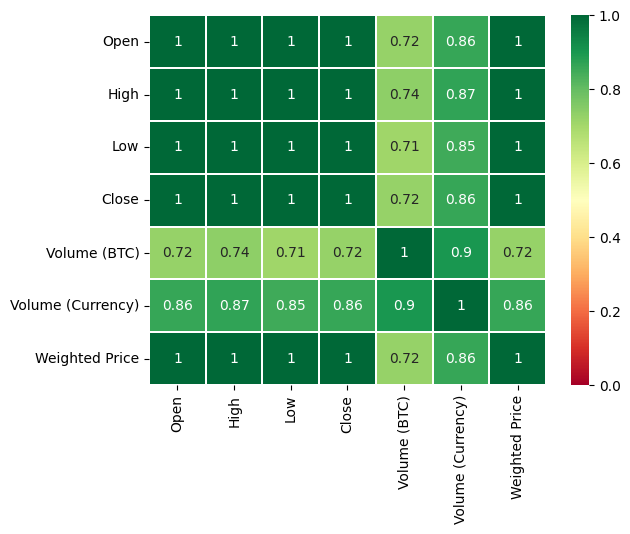

In [34]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [36]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values

values = values.astype('float32')

#### Normalize features to range from 0 to 1

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Frame as supervised learning

In [38]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.116909,0.000715,0.000177,0.116422,0.000878,0.000216
2,0.116422,0.000878,0.000216,0.115041,0.000373,0.000091
3,0.115041,0.000373,0.000091,0.117474,0.000367,0.000091
4,0.117474,0.000367,0.000091,0.125800,0.000858,0.000225
5,0.125800,0.000858,0.000225,0.120299,0.001164,0.000294


#### Drop unncessary columns 

In [39]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.116909   0.000715   0.000177  0.116422
2   0.116422   0.000878   0.000216  0.115041
3   0.115041   0.000373   0.000091  0.117474
4   0.117474   0.000367   0.000091  0.125800
5   0.125800   0.000858   0.000225  0.120299


#### Split data to 70% training, 30% testing

In [40]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(965, 1, 3) (965,) (414, 1, 3) (414,)


#### Training the LSTM model with 300 epochs

In [41]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/300
10/10 [==============================] - 1s 31ms/step - loss: 0.0308 - val_loss: 0.2498
Epoch 2/300
10/10 [==============================] - 0s 17ms/step - loss: 0.0238 - val_loss: 0.2251
Epoch 3/300
10/10 [==============================] - 0s 12ms/step - loss: 0.0230 - val_loss: 0.2138
Epoch 4/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0216 - val_loss: 0.2094
Epoch 5/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0207 - val_loss: 0.2023
Epoch 6/300
10/10 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.1931
Epoch 7/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0198 - val_loss: 0.1846
Epoch 8/300
10/10 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.1760
Epoch 9/300
10/10 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.1682
Epoch 10/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0184 - val_loss: 0.1587
Epoch

#### Training The Second Model Again With Two Additional Dense Layers And Batch Size Equal To 200  

In [42]:
multi_model1 = Sequential()
multi_model1.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model1.add(Dense(1))
multi_model1.add(Dense(4))
multi_model1.add(Dense(1))
multi_model1.compile(loss='mae', optimizer='adam')
multi_history1 = multi_model1.fit(train_X, train_y, epochs=300, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
5/5 - 1s - loss: 0.0346 - val_loss: 0.2797 - 1s/epoch - 269ms/step
Epoch 2/300
5/5 - 0s - loss: 0.0271 - val_loss: 0.2649 - 57ms/epoch - 11ms/step
Epoch 3/300
5/5 - 0s - loss: 0.0243 - val_loss: 0.2553 - 55ms/epoch - 11ms/step
Epoch 4/300
5/5 - 0s - loss: 0.0245 - val_loss: 0.2505 - 62ms/epoch - 12ms/step
Epoch 5/300
5/5 - 0s - loss: 0.0245 - val_loss: 0.2496 - 62ms/epoch - 12ms/step
Epoch 6/300
5/5 - 0s - loss: 0.0242 - val_loss: 0.2507 - 52ms/epoch - 10ms/step
Epoch 7/300
5/5 - 0s - loss: 0.0237 - val_loss: 0.2524 - 77ms/epoch - 15ms/step
Epoch 8/300
5/5 - 0s - loss: 0.0235 - val_loss: 0.2536 - 59ms/epoch - 12ms/step
Epoch 9/300
5/5 - 0s - loss: 0.0235 - val_loss: 0.2537 - 52ms/epoch - 10ms/step
Epoch 10/300
5/5 - 0s - loss: 0.0234 - val_loss: 0.2531 - 51ms/epoch - 10ms/step
Epoch 11/300
5/5 - 0s - loss: 0.0234 - val_loss: 0.2521 - 51ms/epoch - 10ms/step
Epoch 12/300
5/5 - 0s - loss: 0.0233 - val_loss: 0.2508 - 51ms/epoch - 10ms/step
Epoch 13/300
5/5 - 0s - loss: 0.0233 -

#### Plot line graph to show amount loss according the the epoch

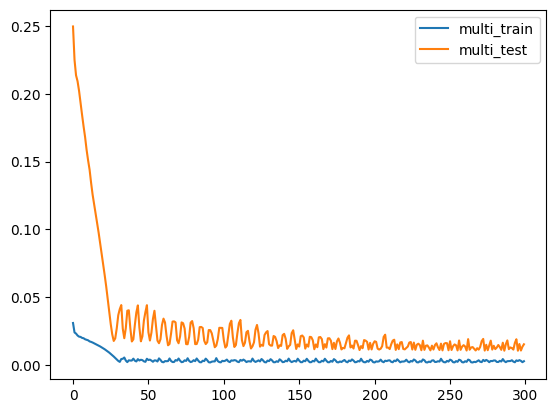

In [45]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

#### Second Model

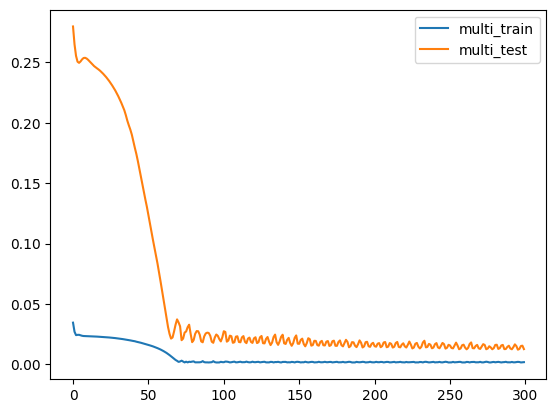

In [46]:
pyplot.plot(multi_history1.history['loss'], label='multi_train')
pyplot.plot(multi_history1.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

### Make prediction using textX and plotting line graph against testY

#### First Model

13/13 [==============================] - 0s 4ms/step


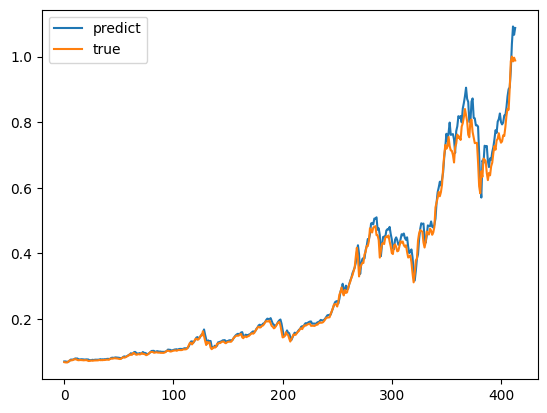

In [49]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Second Model

13/13 [==============================] - 0s 2ms/step


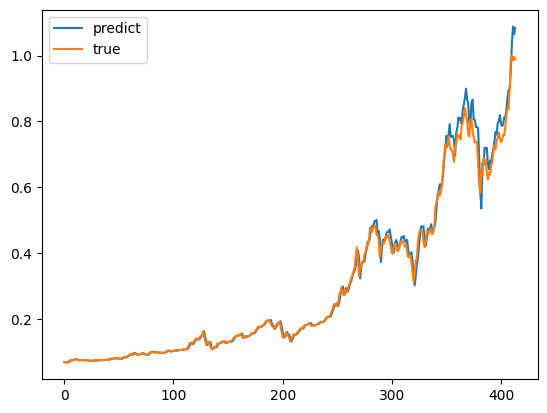

In [50]:
yPred = multi_model1.predict(test_X)
pyplot.plot(yPred, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [51]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yPred = concatenate((yPred, test_X[:, 1:]), axis=1)
inv_yPred = scaler.inverse_transform(inv_yPred)
inv_yPred = inv_yPred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [52]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
secRMSE = sqrt(mean_squared_error(inv_y, inv_yPred))
print('Test RMSE: %.3f' % rmse)
print('Second Test RMSE: %.3f' % secRMSE)

Test RMSE: 142.044
Second Test RMSE: 128.801


#### MAE

In [53]:
MAE = mean_absolute_error(inv_y, inv_yhat)
secMAE = mean_absolute_error(inv_y, inv_yPred)
print('Test MAE: %.3f' % MAE)
print('Second Test MAE: %.3f' %secMAE )

Test MAE: 82.805
Second Test MAE: 69.855


### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

#### First Model

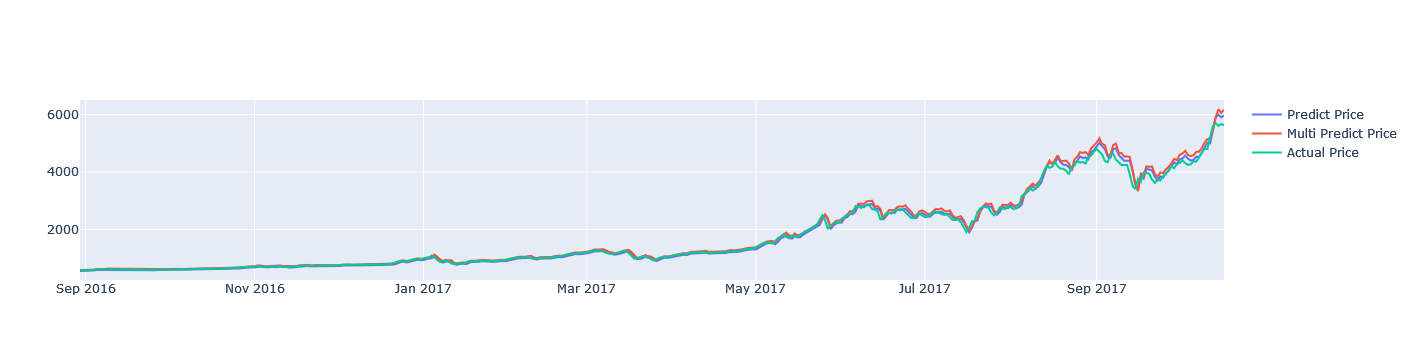

In [54]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

#### Second Model

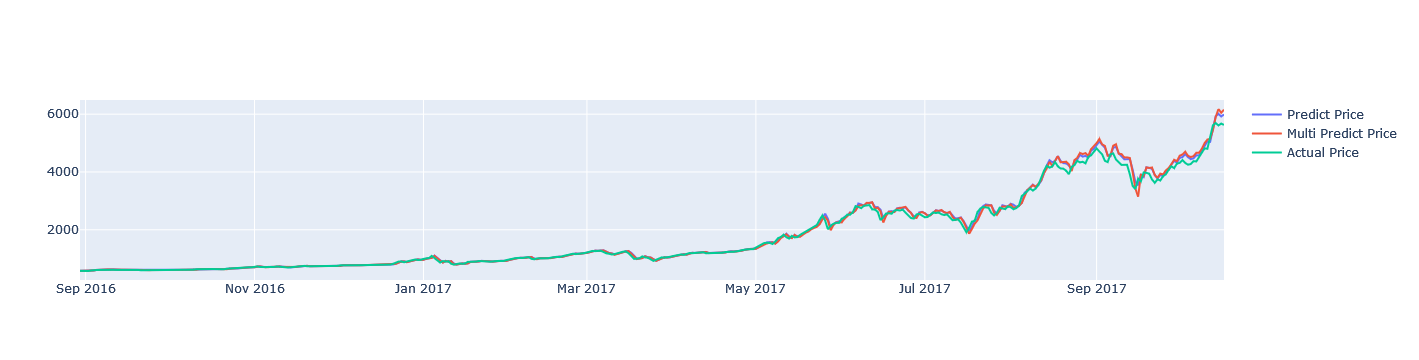

In [56]:
actual_pred_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_pred_chart = go.Scatter(x=predictDates, y=inv_yPred, name= 'Multi Predict Price')
predict_pred_chart = go.Scatter(x=predictDates, y=yPred_reshape, name= 'Predict Price')
py.iplot([predict_pred_chart, multi_predict_pred_chart, actual_pred_chart])

#### Both Model

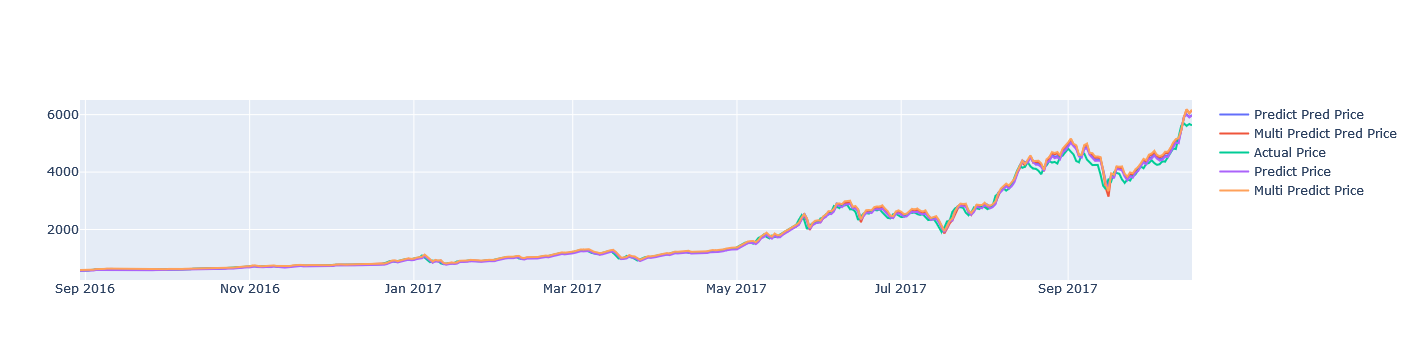

In [57]:
actual_pred_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_pred_chart = go.Scatter(x=predictDates, y=inv_yPred, name= 'Multi Predict Pred Price')
predict_pred_chart = go.Scatter(x=predictDates, y=yPred_reshape, name= 'Predict Pred Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_pred_chart, multi_predict_pred_chart, actual_pred_chart,predict_chart, multi_predict_chart])

- First Model With Single Feature Of `Weighted Price` Has RMSE of 102.960
- Second Model With Single Feature Of `Weighted Price` Has RMSE of 113.171
- First Model With Single Feature Of `Weighted Price` Has MAE of 65.706
- Second Model With Single Feature Of `Weighted Price` Has MAE of 62.889
- First Model With Features Of `Volume(BTC)`, `Volume(Currency)` And `Weighted Price` has RMSE of 142.044
- Second Model With Features Of `Volume(BTC)`, `Volume(Currency)` And `Weighted Price` has RMSE of 128.801
- First Model With Features Of `Volume(BTC)`, `Volume(Currency)` And `Weighted Price` has MAE of 82.805
- Second Model With Features Of `Volume(BTC)`, `Volume(Currency)` And `Weighted Price` has MAE of 69.855

- LSTM with multi features shows more accurate results as show in line chart above